<a href="https://colab.research.google.com/github/AmirrezaJalili/Twitter-Tweets-Sentiment/blob/main/Twitter_Tweets_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Tweets Sentiment 👍😐👎

## Importing necessary tools

In [55]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from random import randint
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

## Unzip data
data: https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset


In [56]:
# !unzip "drive/MyDrive/deep learning/zip files/Twitter Tweets Sentiment Dataset.zip" -d "drive/MyDrive/deep learning/data/Twitter Tweets Sentiment Dataset"

## Walk trough dataset

In [57]:
df = pd.read_csv("drive/MyDrive/deep learning/data/Twitter Tweets Sentiment Dataset/Tweets.csv")
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [58]:
df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

there are missing values in our dataset, 

we'll drop them to make our model work properly

In [59]:
# drop missing values from the dataset
df = df.dropna()
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


row's number decresed only 1 

it looks like there was only one row with two missing values in that. 

In [60]:
#let's find out how many of each class there
df["sentiment"].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

number of each class is ~ 

40%

30%
 
30%

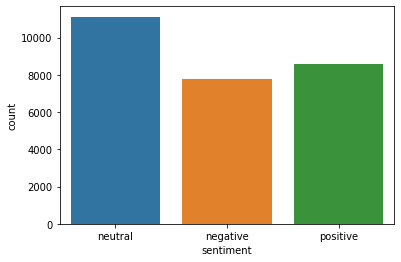

In [61]:
sns.countplot(x = df["sentiment"])
plt.show()

## show some sentences from dataset

In [62]:
for i in range(10):
  num = randint(0, len(df))
  sentence = df["text"][num]
  label = df["sentiment"][num]
  print(f"{label}:\n\t{sentence}")

positive:
	 He needs to go back to his Scotty. That is what he was using when he won last year
neutral:
	 Jared`s wearing a green shirt? *SPARKLY EYES* YEE!! I hear #asylm is highly disorganized  hang in there!
neutral:
	 so go back for more
neutral:
	 Bet she plays on Medium and you play on easy too huh...  #iPhone #Fun #Game
negative:
	 My #followillfriday sucks because while I was teaching people how to be nice, you **** were drooling over Notion
neutral:
	_carter It says the video is private
neutral:
	Is Watching Britains Got Talent, & Is biting her nails. Please don`t come off black nail varnish
neutral:
	just got done washing dishes not too long ago
negative:
	Jeff can`t get his visa in time to come visit me!    I`m so sad.  In other news, I`m going to Lapa tonight to samba the night away.
positive:
	_it_good den fell asleep on me!!!


## split data to train and test
train = 80%

valid = 20%

In [63]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df["text"].to_numpy(),
                                                                            df["sentiment"].to_numpy(),
                                                                            random_state=42,
                                                                            test_size=0.2)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(21984, 21984, 5496, 5496)

## Preprocessing

### binarizing labels:

In [64]:
lb = LabelBinarizer()
train_labels_binary = lb.fit_transform(train_labels)
val_labels_binary = lb.fit_transform(val_labels)
train_labels, val_labels

(array(['positive', 'positive', 'neutral', ..., 'neutral', 'positive',
        'positive'], dtype=object),
 array(['positive', 'negative', 'neutral', ..., 'neutral', 'negative',
        'neutral'], dtype=object))

In [65]:
MEAN_SEQ_LEN = sum([len(i.split()) for i in train_sentences])//len(train_sentences)
print(MEAN_SEQ_LEN)

12


In [66]:
# it's better to set output_sequence_length more than mean length of sentences.  
SEQ_LENGTH = 16

### vectorization(tokenization)

In [67]:
from re import split
text_vectorizer = TextVectorization(max_tokens=10000,
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=SEQ_LENGTH)

## creating model

In [68]:
embedding = layers.Embedding(input_dim=10000,
                                      output_dim=64,
                                      input_length=SEQ_LENGTH,
                                      name="embedding_1")
embedding

In [69]:
text_vectorizer.adapt(train_sentences)
random_sentence = random.choice(train_sentences)
print(f"original sentence:\n\t{random_sentence}\nvectorized sentence:\n\t{text_vectorizer([random_sentence])}\nembedded sentence:\n\t{embedding(text_vectorizer([random_sentence]))}")

original sentence:
	I Sing Everytime
vectorized sentence:
	[[   2  988 2510    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
embedded sentence:
	[[[ 0.01635888 -0.02657862 -0.02555571 ... -0.04594325 -0.03539167
   -0.04630369]
  [-0.01262301 -0.02571693 -0.006283   ... -0.01889594 -0.02839688
   -0.04293185]
  [-0.02181444  0.02398158  0.03788019 ... -0.02289253 -0.04384818
   -0.03892876]
  ...
  [-0.01130103 -0.04374924  0.04810877 ...  0.02003015  0.0248259
   -0.01572717]
  [-0.01130103 -0.04374924  0.04810877 ...  0.02003015  0.0248259
   -0.01572717]
  [-0.01130103 -0.04374924  0.04810877 ...  0.02003015  0.0248259
   -0.01572717]]]


In [70]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_LSTM = tf.keras.Model(inputs, outputs, name="LSTM_model")

In [71]:
model_LSTM.compile(loss="categorical_crossentropy",
              metrics="categorical_accuracy",
              optimizer="Adam")

In [72]:
model_LSTM.fit(train_sentences,
          train_labels_binary,
          validation_data=(val_sentences, val_labels_binary),
          epochs=5,
          batch_size=32)

Epoch 1/5
687/687 [==============================] - 24s 23ms/step - loss: 0.8417 - categorical_accuracy: 0.6049 - val_loss: 0.7579 - val_categorical_accuracy: 0.6872
Epoch 2/5
687/687 [==============================] - 11s 16ms/step - loss: 0.6265 - categorical_accuracy: 0.7436 - val_loss: 0.7460 - val_categorical_accuracy: 0.6841
Epoch 3/5
687/687 [==============================] - 11s 16ms/step - loss: 0.5252 - categorical_accuracy: 0.7963 - val_loss: 0.7693 - val_categorical_accuracy: 0.6789
Epoch 4/5
687/687 [==============================] - 11s 16ms/step - loss: 0.4469 - categorical_accuracy: 0.8287 - val_loss: 0.8081 - val_categorical_accuracy: 0.6710
Epoch 5/5
687/687 [==============================] - 11s 16ms/step - loss: 0.3768 - categorical_accuracy: 0.8567 - val_loss: 1.0598 - val_categorical_accuracy: 0.6601


hmmmmm...
its little bit better than guessing😁😂

but where did i make mistake...?🤔

## Nave Base:
let's try Multinomial Nave Base of sklearn...

In [73]:
labelencoder = LabelEncoder()
train_labels_ml = labelencoder.fit_transform(train_labels)
val_labels_ml = labelencoder.fit_transform(val_labels)
train_labels_ml, val_labels_ml

(array([2, 2, 1, ..., 1, 2, 2]), array([2, 0, 1, ..., 1, 0, 1]))

### Creating model

In [74]:
model_NB = Pipeline([
                     ("tfidf", TfidfVectorizer()),
                     ("NB", MultinomialNB())
])

In [75]:
model_NB.fit(train_sentences, train_labels_ml)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('NB', MultinomialNB())])

In [76]:
model_NB.score(val_sentences, val_labels_ml)

0.606259097525473

ohhh no...!😫

I should try other models in next commits

but really whats wrong with my dataset?🤔

if you have better idea i'll be thankful if you share with me😃
